# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

## Estudiantes: 

- Hernández Mancipe Daniel Felipe
- Panadero de las Heras José Luis 
- Thoux Durán Alejandro Napoleón 
- Velastegui Izurieta Homero Javier 

# **Introducción**

En el presente proyecto se utilizó una instancia **g4dn.2xlarge de** AWS que está diseñada para tareas de aprendizaje automático, inferencia y procesamiento gráfico moderado. Cuenta con 8 vCPUs basadas en procesadores Intel Xeon escalables, 32 GB de memoria RAM y una GPU NVIDIA T4 con 16 GB de memoria de video, lo que permite acelerar modelos de deep learning, análisis de imágenes, renderizado y aplicaciones con CUDA. Además, incluye NVMe local de alto rendimiento (aprox. 225 GB) para acceso rápido a datos temporales, hasta 25 Gbps de ancho de banda de red y soporte para EBS para almacenamiento adicional. Está optimizada para entrenamiento de modelos pequeños o medianos, inferencia en producción, desarrollo de modelos y aplicaciones de visualización 3D.

Dado que se utilizó una instancia remota, algunas etapas del entrenamiento se ejecutaron mediante scripts en Python gestionados con tmux, en lugar de seguir íntegramente la estructura de ejecución típica en Jupyter Notebook. Esto se debe a que Jupyter Lab, aunque útil para exploración, prototipado y visualización, puede interrumpir el entrenamiento si la sesión web se cierra o si existe inestabilidad en la conexión. En cambio, el uso de scripts junto con tmux permite mantener el proceso activo en segundo plano de forma persistente, incluso si el usuario cierra la terminal o el navegador, garantizando continuidad en entrenamientos prolongados.

Por ello, el proyecto se desarrolló de forma híbrida: se realizaron fases de análisis exploratorio, pruebas y visualizaciones en Jupyter Lab, mientras que los entrenamientos definitivos y la ejecución de modelos se llevaron a cabo mediante scripts independientes en la instancia, asegurando estabilidad y reportando los resultados en este documento.


## 1. Descripción del Dataset

El dataset asignado al Grupo 15 fue **Lemon Quality Dataset**,  este es un conjunto de imágenes orientado a la **clasificación automática de la calidad de limones** mediante técnicas de Visión por Computador y Aprendizaje Profundo. El dataset contiene imágenes capturadas bajo condiciones de iluminación natural y fondos uniformes, lo que facilita su uso en modelos basados en redes neuronales convolucionales (CNNs). Las imágenes muestran limones en diferentes estados de calidad, principalmente **limones en buen estado** y **limones deteriorados**, aunque la versión empleada en este proyecto incluye además una categoría adicional que representa **imágenes sin limón**.

## 2. Estructura y Organización del Dataset

En la versión utilizada en este proyecto, el dataset está organizado en tres carpetas, cada una correspondiente a una clase de clasificación:

| Carpeta             | Clase               | Descripción                                                                               |
|--------------------|--------------------|-------------------------------------------------------------------------------------------|
| `good_quality`      | Limón en buen estado | Imágenes de limones con apariencia fresca y sin signos visibles de daño o deterioro.      |
| `bad_quality`       | Limón en mal estado  | Imágenes de limones con señales de deterioro, manchas, podredumbre o deformaciones.       |
| `empty_background`  | Fondo vacío         | Imágenes sin limón útil en la escena; actúa como clase de control negativo.               |

Esta estructura permite formular una **tarea de clasificación multiclase**, donde el modelo debe aprender a distinguir visualmente entre limones buenos, limones en mal estado y ausencia de limón.

Aunque el número de imágenes puede variar según la versión descargada, en el presente proyecto la distribución del conjunto es la siguiente:

| Clase               | Nº aproximado de imágenes | Propósito en la clasificación |
|--------------------|--------------------------|------------------------------|
| `good_quality`       | 1126                    | Representa producto apto para comercialización. |
| `bad_quality`        | 952                     | Permite identificar fruta dañada o no apta.      |
| `empty_background`   | 453   | Ayuda al modelo a descartar imágenes irrelevantes. |

## 3. Objetivo del Dataset en el Contexto del Proyecto

El objetivo central del dataset es **servir como base para el entrenamiento, validación y evaluación de modelos de clasificación de imágenes** que permitan determinar automáticamente el estado de calidad de un limón. Este problema es una tarea de **clasificación visual aplicada**, donde las características que diferencian categorías son sutiles (manchas, textura de la cáscara, coloración, etc.).

En este proyecto, el dataset se empleará para comparar dos estrategias de aprendizaje profundo:

1. **Entrenamiento desde cero (from scratch):**  
   Se diseña y entrenará una CNN personalizada, aplicando técnicas de regularización, ajuste de hiperparámetros y data augmentation para optimizar el rendimiento.

2. **Transfer Learning con redes preentrenadas en ImageNet:**  
   Se utilizara arquitecturas profundas como **VGG, ResNet, MobileNet o Inception**, realizando ajuste fino (fine-tuning) para adaptar la red a la tarea específica de clasificación de limones.

---

# **Desarrollo**

## 1. Carga de datos desde la plataforma Kaggle

En primer lugar se genera un API de Kaggle personal, para ello:
1. Registrarse en  https://www.kaggle.com
2. Ir a 'Account tab' del perfil y seleccionar 'Create API Token', se descargará un `fichero kaggle.json`
3. Guardar el fichero kaggle.json en el directorio `~/.config/kaggle/kaggle.json` de la instancia en la que se ejecutará el entrenamiento.

Una vez colocado el token de acceso de Kaggle, es necesario instalar en la instancia la API, para ello en la terminal de Linux ejecutar:

```bash
pip install kaggle
```

Se puede verificar la instalación con el comando `kaggle datasets list`, si todo está configurado de manera correcta se obtendrá el listado de datasets disponibles. En el caso de que existan problemas, se debe verificar la ruta del archivo kaggle.json. Una vez verificado el acceso se procede a obtener el dataset, para ello se debe ejecutar en la terminal de Linux dentro del directorio del proyecto:

```bash
kaggle datasets download -d yusufemir/lemon-quality-dataset
unzip lemon-quality-dataset.zip
rm lemon-quality-dataset.zip
```

Al finalizar se debe tener un directorio con el dataset esperado con una estructura similar a la siguiente:

```bash
lemon_dataset/
│
├── bad_quality
├── empty_background
└── good_quality
```

## 2. Importar las librerías necesarias

Para poder reproducir la práctica, en la raiz del proyecto se dejó el fichero `requirements.txt`. La instalación de las dependencias se realiza ejecutando en una terminal del Linux, en la raíz del proyecto:

```bash
pip install -r requirements.txt
```

En nuesto proyecto, en la siguiente sección se importan todas las librerías necesarias.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

{'bad': 310, 'empty': 223, 'good': 724}


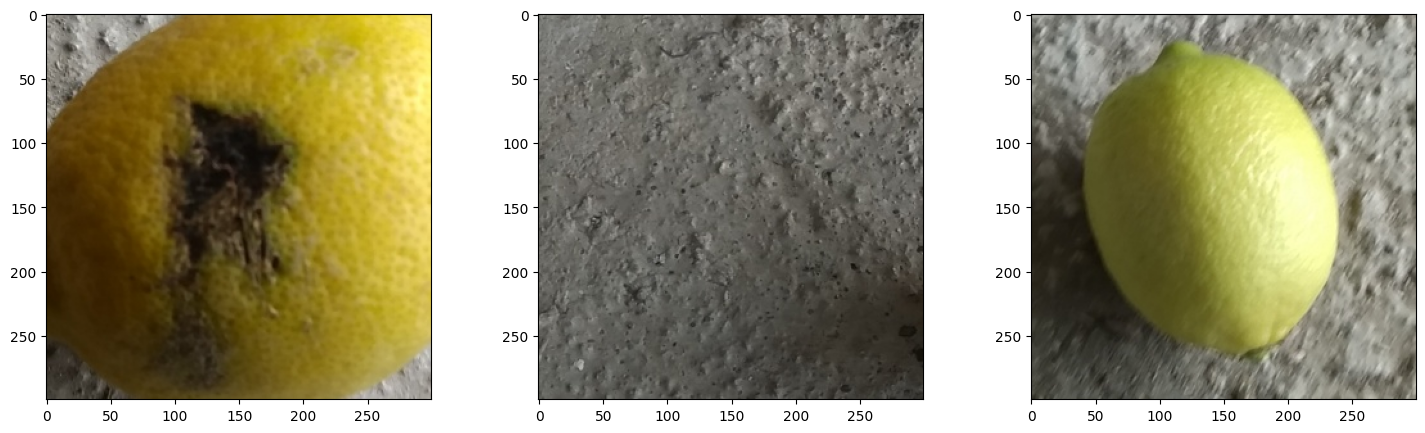

In [38]:


class LemonDataset():
    def __init__(self):
        self.size = {'bad': 952, 'empty': 453, 'good': 1126}
        self.path= {'bad': 'lemon_dataset/bad_quality/bad_quality_', 'empty': 'lemon_dataset/empty_background/empty_background_', 'good': 'lemon_dataset/good_quality/good_quality_'}

    def show_samples(self):
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        idx = {label:np.random.randint(0, self.size[label]) for label in self.size}

        for i, label in enumerate(idx):
            img_path=self.path[label]+str(idx[label])+'.jpg'
            img=cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i].imshow(img)
            
            
            
            
            
        print(idx)

lemon_dataset = LemonDataset()
lemon_dataset.show_samples()



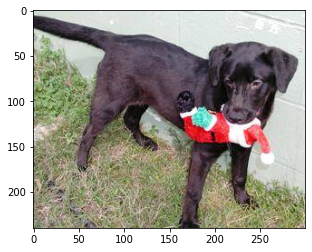

In [ ]:


# Escogiendo y mostrando una imagen al azar del conjunto de test
idx = np.random.randint(1, 12000)
img = cv2.imread('test/' + str(idx) + '.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# Almacenando una imagen aleatoria de test en mi BASE_FOLDER
cv2.imwrite(BASE_FOLDER + 'my_pet.png', img)

True

## Ejemplo de generación de documento PDF a partir del Colab Notebook (fichero ".ipynb")

In [ ]:
# Ejecutando los siguientes comandos en la última celda del Colab Notebook se convierte de ".ipynb" a PDF
# En caso de querer ocultar la salida de una celda puesto que no tenga relevancia se debe insertar
# el comando %%capture al inicio de la misma. Véase la celda que contiene !ls test en este Notebook.

In [ ]:
name_IPYNB_file = '07MIAR_Proyecto_Programacion.ipynb'
get_ipython().system(
        "apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
    )
get_ipython().system(
            "jupyter nbconvert --output-dir='$BASE_FOLDER' '$BASE_FOLDER''$name_IPYNB_file' --to pdf"
        )





[NbConvertApp] Converting notebook /content/drive/MyDrive/07MIAR_Proyecto_Programacion/07MIAR_Proyecto_Programacion.ipynb to pdf
[NbConvertApp] Support files will be in 07MIAR_Proyecto_Programacion_files/
[NbConvertApp] Making directory ./07MIAR_Proyecto_Programacion_files
[NbConvertApp] Writing 43232 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 179055 bytes to /content/drive/MyDrive/07MIAR_Proyecto_Programacion/07MIAR_Proyecto_Programacion.pdf
